This file applies built-in MHA, no mask, non normalize Y

# PARAMETERS

In [13]:
%run tf_helpers.py
%run tf_attention_noMask.py

DATA_SIZE = 4000
FOLDERS = ['SiouxFalls/Output1'] # full links
TRAIN_RATE = 0.7
VAL_RATE = 0.2
TEST_RATE = 0.1
BATCH_SIZE = 64

# TRAINING 
device = 'gpu'
input_dim = 6
output_dim = 3
d_model = 128
heads=8
E_layer = 8
D_layer = 2
epochs = 500
learning_rate = 0.001
dropout=0.1
l2_reg=1e-6

# CREATE DATASET

In [12]:
files = load_files_from_folders(FOLDERS, max_files=100)
path_set_dict = path_encoder(files)
print("Path set number: ", len(path_set_dict))

class Dataset:
    def __init__(self, files):
        # self.path_encoded = path_encoder()  # Get path encode dictionary
        self.X = []
        self.Y = []

        for file_name in tqdm(files):
            x, y = generate_xy(file_name, path_set_dict)
            self.X.append(x)
            self.Y.append(y)

        self.X = tf.stack(self.X, axis=0)
        self.Y = tf.stack(self.Y, axis=0)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

    def to_tf_dataset(self, batch_size):
        dataset = tf.data.Dataset.from_tensor_slices((self.X, self.Y))
        dataset = dataset.shuffle(buffer_size=len(self.X)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
        return dataset

def get_test_set(files):
    X = []
    Y = []
    Scalers = []
    for file_name in tqdm(files) :
        x, y, scaler = generate_xy(file_name, path_set_dict, test_set=True)
        X.append(x)
        Y.append(y)
        Scalers.append(scaler)

    X = tf.stack(X, axis=0)
    Y = tf.stack(Y, axis=0)
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return dataset, Scalers

Path set number:  1656


In [16]:
%run tf_helpers.py

files = load_files_from_folders(FOLDERS, max_files=DATA_SIZE)
train_files, val_files, test_files = split_dataset(files, TRAIN_RATE, VAL_RATE)

train_dataset = Dataset(train_files)
train_data_loader = train_dataset.to_tf_dataset(BATCH_SIZE)

val_dataset = Dataset(val_files)
val_data_loader = train_dataset.to_tf_dataset(BATCH_SIZE)

# test_dataset = Dataset(test_files)
# test_data_loader = test_dataset.to_tf_dataset(BATCH_SIZE)
test_data_loader, scalers = get_test_set(test_files)

  0%|          | 0/400 [00:00<?, ?it/s]

# TRAIN MODEL

In [15]:
from tensorflow.keras.optimizers import Adam  
from tensorflow.keras.losses import MeanSquaredError
import time
%run tf_attention_noMask.py

# normalize Y by row, difference normalize X 
# sigmoid activate
# ignore 1st layernorm in decoder
model = Transformer(input_dim=input_dim, output_dim=output_dim,
                    d_model=d_model, E_layer=E_layer, D_layer=D_layer,
                    heads=heads, dropout=dropout, l2_reg=l2_reg)
loss_fn = MeanSquaredError()
optimizer = Adam(learning_rate=learning_rate, clipvalue=1.0, decay=l2_reg)

start = time.time()
model, train_loss, val_loss = model.fit(train_data_loader, val_data_loader, optimizer, loss_fn, epochs, device)
end = time.time()
train_time = end-start

  0%|          | 0/500 [00:00<?, ?epoch/s]

Epoch: 1 - Train Loss: 0.1612, Val Loss: 0.1562
Epoch: 2 - Train Loss: 0.1519, Val Loss: 0.1475
Epoch: 3 - Train Loss: 0.1434, Val Loss: 0.1392
Epoch: 4 - Train Loss: 0.1353, Val Loss: 0.1313
Epoch: 5 - Train Loss: 0.1276, Val Loss: 0.1238
Epoch: 6 - Train Loss: 0.1203, Val Loss: 0.1167
Epoch: 7 - Train Loss: 0.1134, Val Loss: 0.1101
Epoch: 8 - Train Loss: 0.1070, Val Loss: 0.1039
Epoch: 9 - Train Loss: 0.1010, Val Loss: 0.0981
Epoch: 10 - Train Loss: 0.0955, Val Loss: 0.0929
Epoch: 11 - Train Loss: 0.0905, Val Loss: 0.0880
Epoch: 12 - Train Loss: 0.0859, Val Loss: 0.0837
Epoch: 13 - Train Loss: 0.0817, Val Loss: 0.0797
Epoch: 14 - Train Loss: 0.0780, Val Loss: 0.0762
Epoch: 15 - Train Loss: 0.0746, Val Loss: 0.0730
Epoch: 16 - Train Loss: 0.0716, Val Loss: 0.0701
Epoch: 17 - Train Loss: 0.0689, Val Loss: 0.0676
Epoch: 18 - Train Loss: 0.0664, Val Loss: 0.0653
Epoch: 19 - Train Loss: 0.0643, Val Loss: 0.0632
Epoch: 20 - Train Loss: 0.0623, Val Loss: 0.0614
Epoch: 21 - Train Loss: 0.060

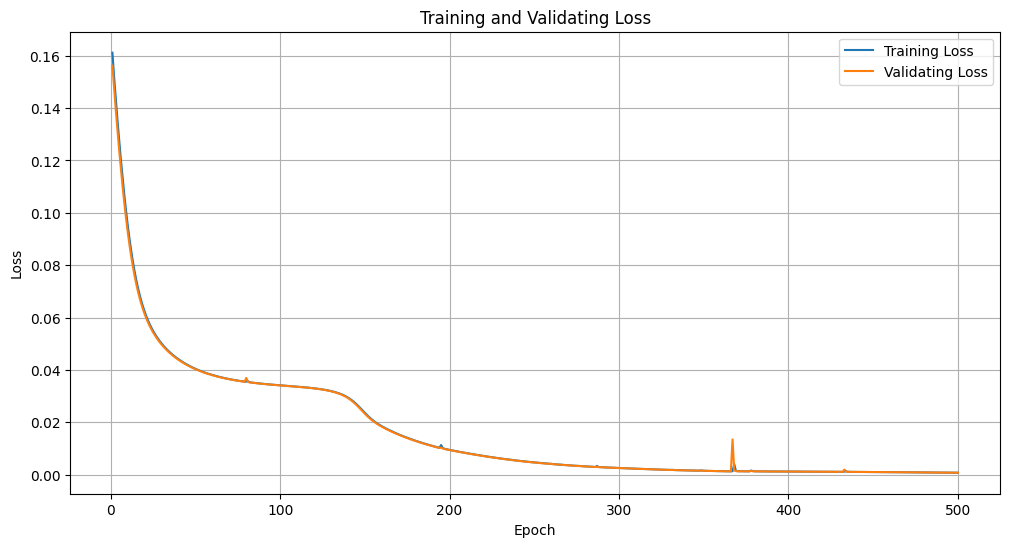

In [17]:
%run plotting.py
plot_loss(train_loss, val_loss, epochs)

# CHECK DELAY OF PREDICTED VALUES

In [18]:
def inversed(normed, scaler):
    # normed: 625x3
    tensor = scaler.inverse_transform(np.transpose(normed))
    tensor = np.transpose(tensor)
    return tensor

def predict_withScaler(model, test_data_loader, scalers, device):
    model.eval()
    predicted_values = []
    scaler_idx = 0
    for src, trg in test_data_loader:
        with tf.device(device):
            # output = model.predict(src, src_mask, tgt_mask)
            output = model.call(src, trg)
            for i in range(len(src)):
                scaler = scalers[scaler_idx]
                scaler_idx +=1
                pred_matrix = inversed(output[i].numpy(), scaler)
                predicted_values.append(pred_matrix)

    return predicted_values

def predict_percentage(model, test_data_loader, device):
    model.eval()
    predicted_values = []
    for src, trg in test_data_loader:
        with tf.device(device):
            output = model.call(src, trg)
            for i in range(len(src)):
                predicted_values.append(output[i].numpy())

    return predicted_values

pred_tensor = predict_withScaler(model, test_data_loader, scalers, device)
# pred_tensor = predict_percentage(model, test_data_loader, device)

In [118]:
%run tf_helpers.py
import pandas as pd
import numpy as np

i = 2
file_name = test_files[i]
stat = read_file(file_name)
demand = stat["data"]["demand"]
pred_df, _, _, _ = create_pred_df(pred_tensor[i], stat)
# pred_df['flow1'] = pred_df['flow1']*pred_df['demand']
# pred_df['flow2'] = pred_df['flow2']*pred_df['demand']
# pred_df['flow3'] = pred_df['flow3']*pred_df['demand']

# Predicted link and path flow
pred_link_flow = sum_pred_link_flow(pred_df, stat)
pred_df, pred_avg_delay = calculate_delay(pred_df, pred_link_flow)

# Solution link and path flow
UE_link, path_link_df, avg_path_cost = mean_path_cost(stat)

[link_flow, path_flow],delays, lens, _, _ = single_avg_delay(pred_tensor[i], file_name)

def calculate_indicator(df):
    mse = np.mean(df['sqr_err'])
    mae = np.mean(df['abs_err'])
    rmse = np.sqrt(mse)
    mape = np.mean(df['abs_err'][df['UE_flow']!=0]/df['UE_flow'][df['UE_flow']!=0])*100
    return [mae, rmse, mape]

,Indicator,Link flow,Path flow
0,MAE,3690.538462,80.196347
1,RMSE,4675.192197,169.832432
2,MAPE,155.490410,12.702329


  0%|          | 0/400 [00:00<?, ?it/s]

Avg path cost:  89.7925 mins
Prediction average delay:  0.7112 mins =  0.79 %
Solution average delay:  0.0532 mins
Difference: 0.658 mins


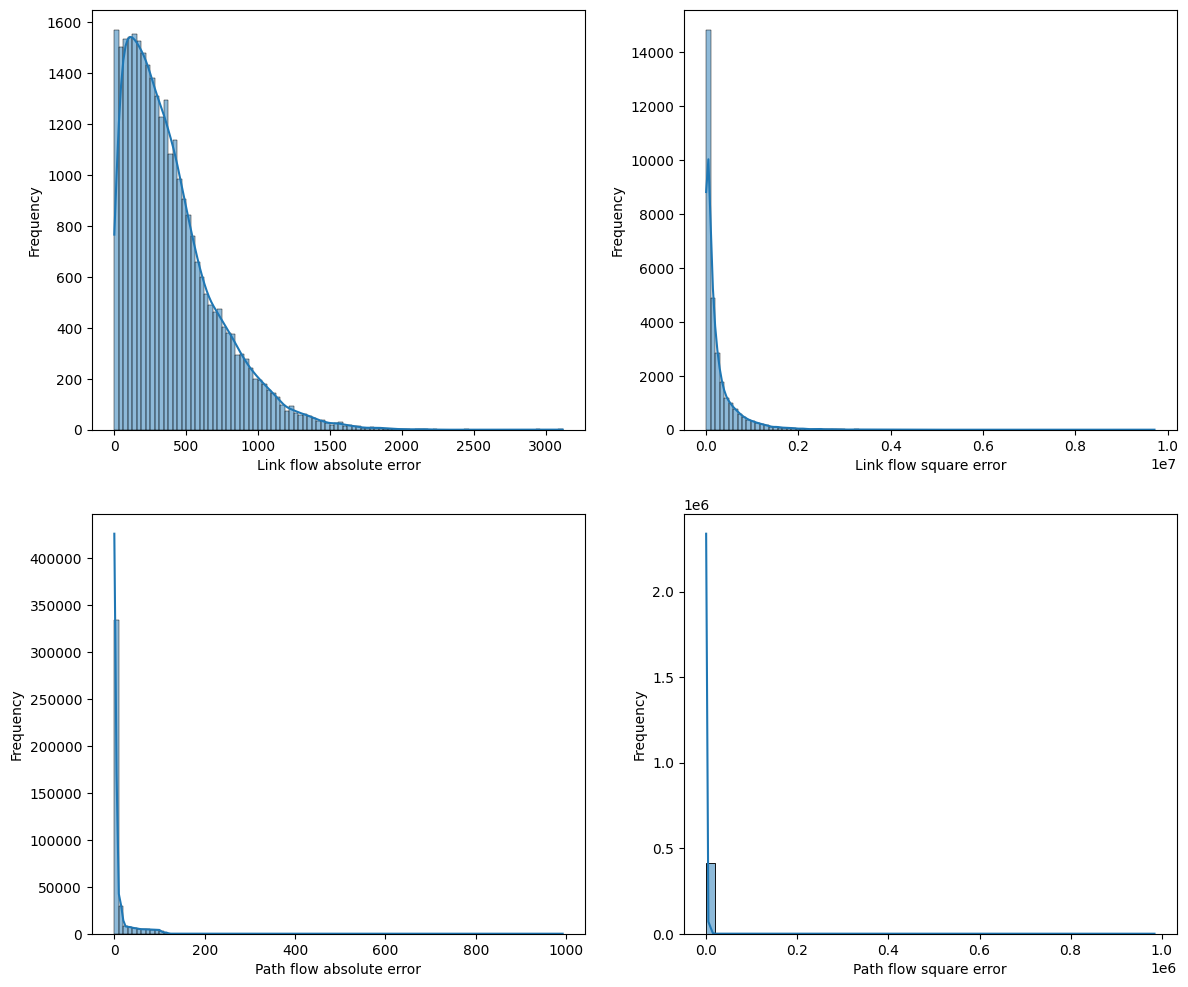

In [19]:
import numpy as np

def single_avg_delay(pred_tensor, filename):
    """ len_origin: number of OD pair in origin dataset
    len_pred: number of OD pair in predicted value
    nan_num: number of nan value 
    """
    stat = read_file(filename)
    pred_df, len_origin, len_pred, nan_num = create_pred_df(pred_tensor, stat)
    pred_link_flow = sum_pred_link_flow(pred_df, stat)
    # Avg delay of predicted flow
    pred_df, pred_avg_delay = calculate_delay(pred_df, pred_link_flow)
    # Avg delay of solution
    UE_link, path_link_df, avg_path_cost = mean_path_cost(stat)
    a, solution_avg_delay = calculate_delay(path_link_df, UE_link)

    link_flow = compare_link_flow(UE_link, pred_link_flow)
    path_flow = compare_path_flow(path_link_df, pred_df)
    return [link_flow, path_flow],[pred_avg_delay, solution_avg_delay], [len_pred, len_origin], nan_num, avg_path_cost

size = len(test_files)

Avg_delay, Solution_avg_delay, Len_origin, Len_pred, Nan_num, Avg_path_cost = [], [], [], [], [], []
Link_flow, Path_flow = [], []
for i, filename in tqdm(zip(pred_tensor[:size], test_files[:size]), total=size):
    flows, delays, lens, nan_num, avg_path_cost = single_avg_delay(i, filename)

    Avg_delay.append(delays[0])
    Solution_avg_delay.append(delays[1])
    Len_pred.append(lens[0])
    Len_origin.append(lens[1])
    Nan_num.append(nan_num)
    Avg_path_cost.append(avg_path_cost)
    Link_flow.append(flows[0])
    Path_flow.append(flows[1])

df = pd.DataFrame({
    'origin_od_pair': Len_origin,
    'pred_od_pair': Len_pred,
    'nan_percentage': Nan_num,
    'Pred_ad': Avg_delay,
    'Solution_ad': Solution_avg_delay
})
df.to_csv("predicted_result.csv")
p = np.mean(Avg_delay)
s = np.mean(Solution_avg_delay)
print("Avg path cost: ", round(np.mean(Avg_path_cost), 4), "mins")
print("Prediction average delay: ", round(p,4), "mins = ", round(p/np.mean(Avg_path_cost)*100, 2), "%")
print("Solution average delay: ", round(s, 4), "mins")
print(f"Difference: {round(p-s,4)} mins")

plot_error(Link_flow, Path_flow)

  Indicator   Link flow  Path flow
0       MAE  394.276118  10.264836
1      RMSE  505.573684  34.948635
2      MAPE    2.609553   4.159807


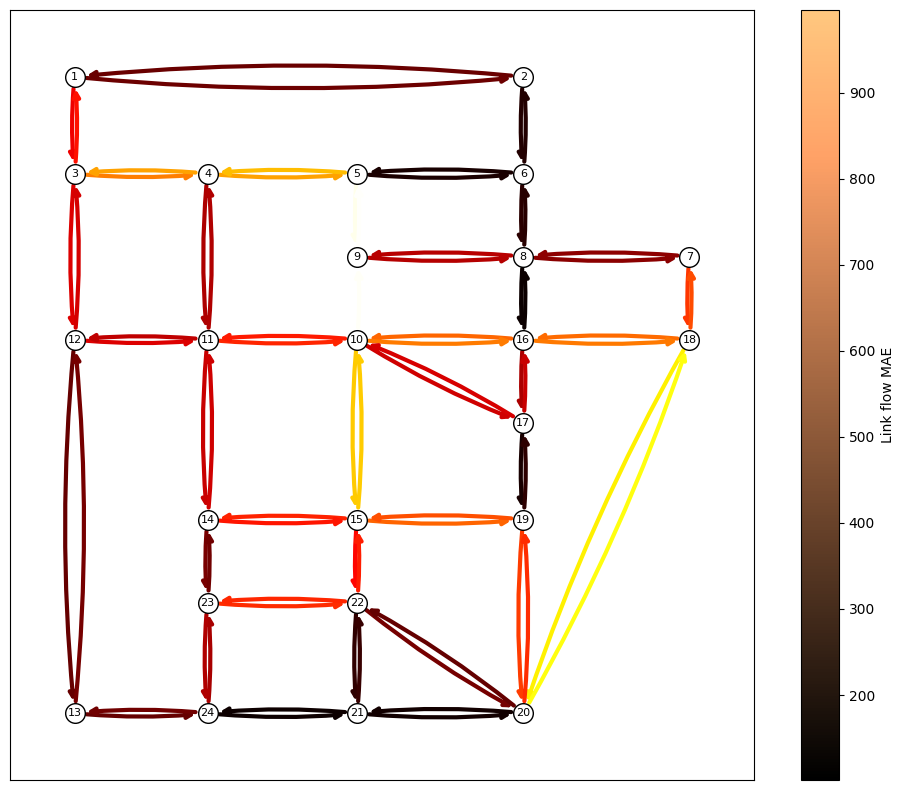

In [20]:
%run plotting.py

link_indicator = calculate_indicator(Link_flow)
path_indicator = calculate_indicator(Path_flow)
rows = ['MAE', 'RMSE', 'MAPE']
result = pd.DataFrame({'Indicator': rows, 
                       'Link flow': link_indicator, 
                       'Path flow': path_indicator})
print(result)
Link_mae_df = heatmap_link_mae(Link_flow, test_files[0], 0)